# W2 Discussion

## Linear Regression in PyTorch:

Recall that for Linear Regression:

- Training Data: $S = \{x_i,y_i\}_{i=1}^N$
- Model Class: $f(x|w,b) = w^Tx - b$
- Loss Function: $L(a,b) = (a-b)^2$

In [1]:
import torch, numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 1.13.1+cpu


# Create Toy Data

Let us create a toy data. Assume that there is some underlying linear function that we model, and we'll add some Gaussian Noise. 

Our underlying function in this example is f(x) = 4.2x - 12.5, and we will add Gaussian noise to f(x) with $\sigma=3.0$

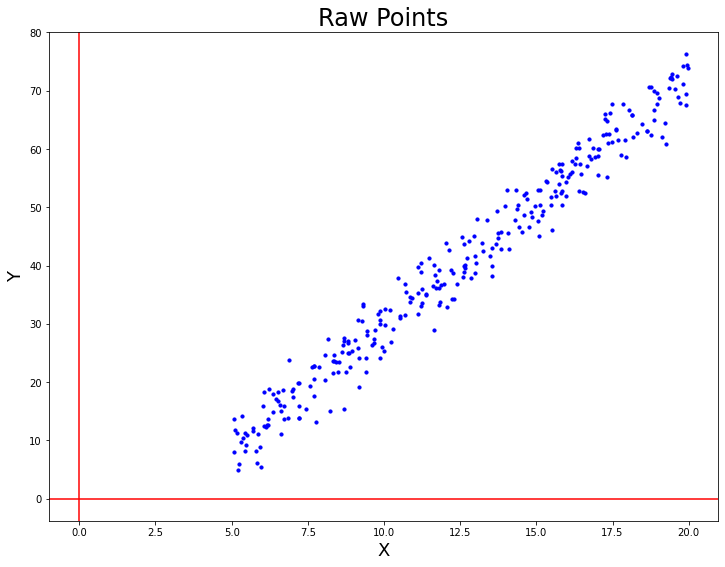

In [2]:
def toy_data(intended_fn, noise_std):
  distribution = torch.distributions.uniform.Uniform(low = 5, high = 20)
  X = distribution.sample(sample_shape = (300,))
  
  # Can also use torch.distributions.normal
  noise = torch.normal(mean = 0, std = noise_std, size = (300,))
  y = intended_fn(X) + noise
  return X, y

def linear_fn(x):
  return 4.2 * x - 12.5

colors = ["b", "r"]

def visualize_data(Xs, ys, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red")
  plt.axvline(color="red")
  for points_idx, (X, y) in enumerate(zip(Xs, ys)):
    plt.scatter(X, y, s=10, c=colors[points_idx])
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("X", fontsize=18)
  plt.ylabel("Y", fontsize=18)
  
raw_X, raw_y = toy_data(linear_fn, 3.0)
visualize_data([raw_X], [raw_y], "Raw Points")

# Define a Training / Testing Dataset

We want to test how our dataset generalizes to **unseen** data. To represent unseen data, we will select 
- 90% of our samples as training data (what we use to train a model / learn parameters)
- 10% as test data (see how well our model generalizes to unseen data)

Ideally, both the training and test data should be identically distributed. In the real world, you may have a dataset and randomly split into training/test splits or training/validation/test splits to somewhat accomplish this. 

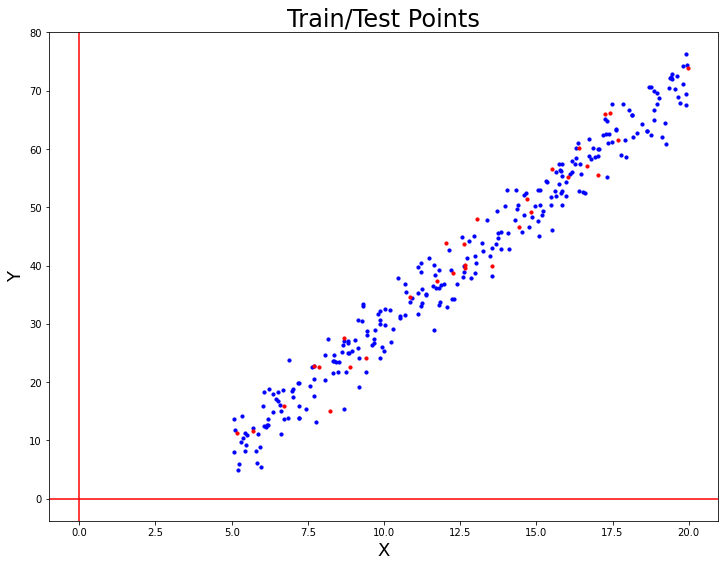

In [3]:
perm = torch.randperm(300)

train_idx, test_idx = perm[:270], perm[270:]
X_tr, y_tr = raw_X[train_idx], raw_y[train_idx]
X_te, y_te = raw_X[test_idx], raw_y[test_idx]

visualize_data([X_tr, X_te], [y_tr, y_te], "Train/Test Points")

# PyTorch Linear Regression

Let us construct a very simple neural network with 1 linear layer (2 parameters, 1 weight and 1 bias) and train it using:
- Training Data: $S = {x_i,y_i}_{i=1}^N$
- Model Class: $f(x|w,b) = w^Tx - b$
- Loss Function: $L(a,b) = (a-b)^2$

Note: There is an analytical solution to the Least-Squares Linear Regression problem using the pseudo-inverse. We are using gradient descent to solve it just as an example.

In [4]:
# Append Bias Columns of 1's. This way one matrix multiplication can also fit an intercept
X_train, X_test = X_tr.reshape((-1, 1)), X_te.reshape((-1, 1))
y_train, y_test = y_tr.reshape((-1, 1)), y_te.reshape((-1, 1))
print(X_train.shape, X_test.shape)

torch.Size([270, 1]) torch.Size([30, 1])


In [5]:
# Define Model
model = torch.nn.Sequential(
  torch.nn.Linear(1, 1)
)

# Define Loss Function / Objective Function
loss_fn = torch.nn.MSELoss()

# Define optimizer (this will perform your parameter updates use)
lr = 5e-3
opt = torch.optim.SGD(model.parameters(), lr=lr)


In [6]:
train_err = []
test_err = []
parameters = []
for i in range(10000):
  model.train()
  
  y_pred = model(X_train) # Compute model outputs
  loss = loss_fn(y_pred, y_train) # Compute MSE
  opt.zero_grad() # Must reset the gradients every step. Otherwise, gradients from previous iterations would cause interference!!!
  loss.backward() # Compute gradients of all parameters (our model) with respect to our computed loss value (a singular value)
  opt.step() # One gradient step
  
  train_err.append(loss.item())
  
  model.eval()
  with torch.no_grad():
    test_err.append(loss_fn(model(X_test), y_test).item())

In [7]:
print(f"Final Model: {model[0].weight.item()} {model[0].bias.item()}")

Final Model: 4.2267842292785645 -12.57923412322998


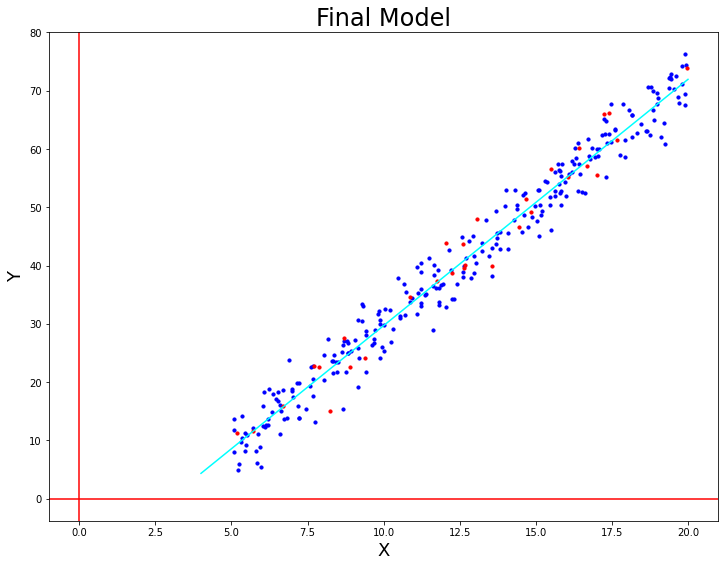

In [8]:
visualize_data([X_tr, X_te], [y_tr, y_te], "Final Model")

with torch.no_grad():
  line_x = torch.linspace(4, 20, 100)
  line_y = model(line_x.reshape((-1, 1))).flatten()
  plt.plot(line_x, line_y, color="cyan")

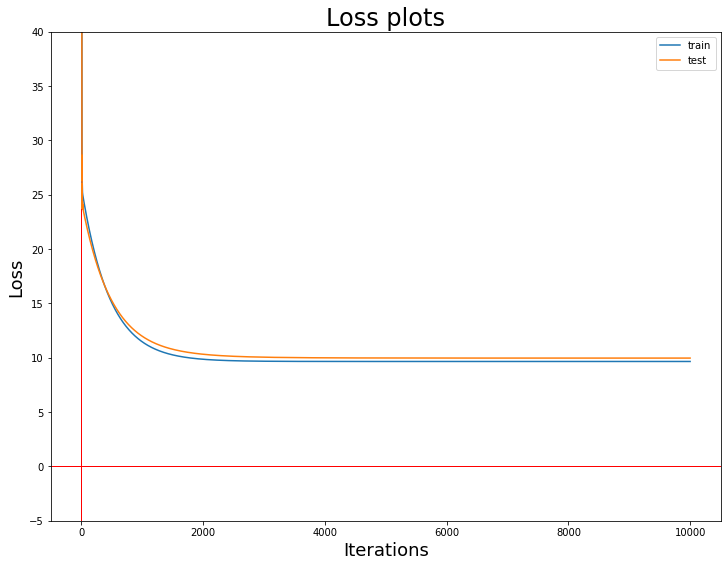

In [9]:
def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(-5, 40)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")